# Advanced Linear Regression
## House Price Prediction - Assignment Solution

#### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.The company is looking at prospective properties to buy to enter the market.

The company wants to know:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.


The solution is divided into the following sections: 
- Data Understanding 
- Data Cleaning & Preparation
- Model building and evaluation
- Inference

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


### 1. Data Understanding 

Importing the required libraries and taking a look at the dataset

In [2]:
#Reading the csv
House_attributes= pd.read_csv('train.csv')

In [3]:
#First few rows
House_attributes.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#checking for duplicates
sum(House_attributes.duplicated(subset = 'Id')) == 0

True

In [5]:
# Summary of the dataset: 1460 rows, 81 columns and there NULL values which will be treated in the next section
print(House_attributes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 2. Data  Cleaning & Preparation

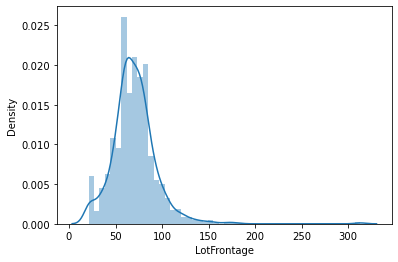

In [6]:
sns.distplot(House_attributes['LotFrontage'])
plt.show()
#LotFrontage has 1201 non null values at seen in the previous line of code

In [7]:
# Data Dictionary says, "LotFrontage" is Linear feet of street connected to property.  
# Since it is a numeric with a fair distribution, it can be imputed with similar 'Neighborhood' values

House_attributes['LotFrontage'] = House_attributes.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

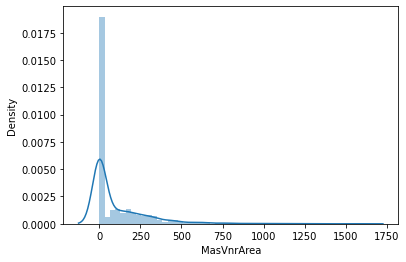

In [8]:
sns.distplot(House_attributes['MasVnrArea'])
plt.show()


In [9]:
#Median is cleary 0. Hence filling the nans with 0
House_attributes['MasVnrArea']=House_attributes['MasVnrArea'].fillna(0)

#### There are many categorical variables which in which nulls suggest the absence of that facility as per the data dictionary. Hence treating the nulls accordingly. There are few cases where the null values are replaced with medians



In [10]:
set(House_attributes['Alley'])

{'Grvl', 'Pave', nan}

In [11]:
House_attributes['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [12]:
#nan replaced with NA which basically means there is no alley for the house
House_attributes['Alley']=House_attributes['Alley'].fillna('NA')

In [13]:
set(House_attributes['MasVnrType'])

{'BrkCmn', 'BrkFace', 'None', 'Stone', nan}

In [14]:
House_attributes['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [15]:
#nan replaced with None category which is also the median value
House_attributes['MasVnrType']=House_attributes['MasVnrType'].fillna('None')

In [16]:
House_attributes['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [17]:
set(House_attributes['BsmtQual'])

{'Ex', 'Fa', 'Gd', 'TA', nan}

In [18]:
#Replacing nan with 'NA' which which means Basement in not available
House_attributes['BsmtQual']=House_attributes['BsmtQual'].fillna('NA')

In [19]:
set(House_attributes['BsmtCond'])

{'Fa', 'Gd', 'Po', 'TA', nan}

In [20]:
House_attributes['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [21]:
#Replacing nan with 'NA' which which means Basement in not available
House_attributes['BsmtCond']=House_attributes['BsmtCond'].fillna('NA')

In [22]:
set(House_attributes['BsmtExposure'])

{'Av', 'Gd', 'Mn', 'No', nan}

In [23]:
House_attributes['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [24]:
#Replacing nan with 'NA' which which means Basement in not available
House_attributes['BsmtExposure']=House_attributes['BsmtExposure'].fillna('NA')

In [25]:
set(House_attributes['BsmtFinType1'])

{'ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf', nan}

In [26]:
House_attributes['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [27]:
#Replacing nan with 'NA' which which means Basement in not available
House_attributes['BsmtFinType1']=House_attributes['BsmtFinType1'].fillna('NA')

In [28]:
set(House_attributes['BsmtFinType2'])

{'ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf', nan}

In [29]:
House_attributes['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [30]:
#Replacing nan with 'NA' which which means Basement in not available
House_attributes['BsmtFinType2']=House_attributes['BsmtFinType2'].fillna('NA')

In [31]:
set(House_attributes['Electrical'])

{'FuseA', 'FuseF', 'FuseP', 'Mix', 'SBrkr', nan}

In [32]:
House_attributes['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [33]:
# It has only 1 nan which can be replaced with the SBrkr which is the median value
House_attributes['Electrical']=House_attributes['Electrical'].fillna('SBrkr')

In [34]:
set(House_attributes['FireplaceQu'])

{'Ex', 'Fa', 'Gd', 'Po', 'TA', nan}

In [35]:
House_attributes['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [36]:
#Replacing nan with 'NA' which which means Fireplace in not available
House_attributes['FireplaceQu']=House_attributes['FireplaceQu'].fillna('NA')

In [37]:
set(House_attributes['GarageType'])

{'2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', nan}

In [38]:
House_attributes['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [39]:
#Replacing nan with 'NA' which which means Garage in not available
House_attributes['GarageType']=House_attributes['GarageType'].fillna('NA')

In [40]:
set(House_attributes['GarageYrBlt'])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1900.0,
 1906.0,
 1908.0,
 1910.0,
 nan,
 nan,
 1914.0,
 1915.0,
 1916.0,
 nan,
 1918.0,
 nan,
 1920.0,
 1921.0,
 1922.0,
 1923.0,
 1924.0,
 1925.0,
 1926.0,
 1927.0,
 1928.0,
 1929.0,
 1930.0,
 1931.0,
 1932.0,
 1933.0,
 1934.0,
 1935.0,
 1936.0,
 1937.0,
 1938.0,
 1939.0,
 1940.0,
 1941.0,
 1942.0,
 1945.0,
 1946.0,
 1947.0,
 1948.0,
 1949.0,
 1950.0,
 1951.0,
 1952.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 

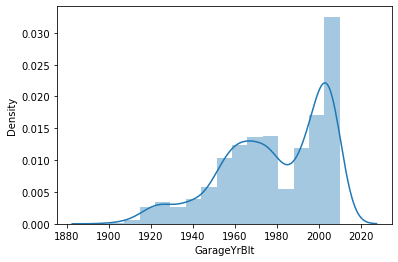

In [41]:
sns.distplot(House_attributes['GarageYrBlt'])
plt.show()

In [42]:
#Has ~81 nulls seen in the info command.
#And filling here with median doesnt makes sense, cause basically garages were not available for these
#And as total rows are only 1460 ,dropping those rows cant be afforded hence dropping it
House_attributes['GarageYrBlt']=House_attributes.drop(['GarageYrBlt'],axis=1,inplace=True)    


In [43]:
set(House_attributes['GarageFinish'])

{'Fin', 'RFn', 'Unf', nan}

In [44]:
#Replacing nan with 'NA' which which means Garage in not available
House_attributes['GarageFinish']=House_attributes['GarageFinish'].fillna('NA')

In [45]:
set(House_attributes['GarageQual'])

{'Ex', 'Fa', 'Gd', 'Po', 'TA', nan}

In [46]:
#Replacing nan with 'NA' which which means Garage in not available
House_attributes['GarageQual']=House_attributes['GarageQual'].fillna('NA')

In [47]:
set(House_attributes['GarageCond'])

{'Ex', 'Fa', 'Gd', 'Po', 'TA', nan}

In [48]:
#Replacing nan with 'NA' which which means Garage in not available
House_attributes['GarageCond']=House_attributes['GarageCond'].fillna('NA')

In [49]:
set(House_attributes['PoolQC'])

{'Ex', 'Fa', 'Gd', nan}

In [50]:
#Replacing nan with 'NA' which which means Pool in not available
House_attributes['PoolQC']=House_attributes['PoolQC'].fillna('NA')

In [51]:
set(House_attributes['Fence'])

{'GdPrv', 'GdWo', 'MnPrv', 'MnWw', nan}

In [52]:
#Replacing nan with 'NA' which which means Fence in not available
House_attributes['Fence']=House_attributes['Fence'].fillna('NA')

In [53]:
set(House_attributes['MiscFeature'])

{'Gar2', 'Othr', 'Shed', 'TenC', nan}

In [54]:
House_attributes['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [55]:
#Replacing nan with 'NA' which which means there is no additional miscellaneous feature available
House_attributes['MiscFeature']=House_attributes['MiscFeature'].fillna('NA')

#### Creating a few new/derived columns

In [56]:
House_attributes.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBlt
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,208500,None


In [57]:
House_attributes[['YearBuilt','YearRemodAdd']].head(5)

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000


In [58]:
House_attributes[['YearBuilt','YearRemodAdd']].max()

YearBuilt       2010
YearRemodAdd    2010
dtype: int64

In [59]:
#Creating a remodelling flag
House_attributes['Remod_Flag']=np.where(House_attributes['YearRemodAdd']==House_attributes['YearBuilt'],0,1)

In [60]:
set(House_attributes['Remod_Flag'])

{0, 1}

In [61]:
# Creating PropAge column :  yearsold - yearbuilt
House_attributes['PropAge'] = (House_attributes['YrSold'] - House_attributes['YearBuilt'])
House_attributes.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBlt,Remod_Flag,PropAge
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,0,2,2008,WD,Normal,208500,None,0,5
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,0,5,2007,WD,Normal,181500,None,0,31
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,0,9,2008,WD,Normal,223500,None,1,7
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,0,2,2006,WD,Abnorml,140000,None,1,91
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,0,12,2008,WD,Normal,250000,None,0,8


In [62]:
# Now we can drop the column Month sold and Year Sold, Year built and Year remodelled since it will not be required further
#We have already taken care of these by creating derived columns above
House_attributes = House_attributes.drop(['MoSold'], axis = 1)
House_attributes = House_attributes.drop(['YrSold'], axis = 1)
House_attributes = House_attributes.drop(['YearBuilt'], axis = 1)
House_attributes = House_attributes.drop(['YearRemodAdd'], axis = 1)
House_attributes.head()

#Dropping the id column
House_attributes.drop(['Id'],axis=1,inplace=True)   

#### Converting from int type to object to create dummy columns for the categorical columns


In [63]:
House_attributes['MSSubClass'] = House_attributes['MSSubClass'].astype('object')
House_attributes['OverallQual'] = House_attributes['OverallQual'].astype('object')
House_attributes['OverallCond'] = House_attributes['OverallCond'].astype('object')
House_attributes['BsmtFullBath'] = House_attributes['BsmtFullBath'].astype('object')
House_attributes['BsmtHalfBath'] = House_attributes['BsmtHalfBath'].astype('object')
House_attributes['FullBath'] = House_attributes['FullBath'].astype('object')
House_attributes['HalfBath'] = House_attributes['HalfBath'].astype('object')
House_attributes['BedroomAbvGr'] = House_attributes['BedroomAbvGr'].astype('object')
House_attributes['KitchenAbvGr'] = House_attributes['KitchenAbvGr'].astype('object')
House_attributes['TotRmsAbvGrd'] = House_attributes['TotRmsAbvGrd'].astype('object')
House_attributes['Fireplaces'] = House_attributes['Fireplaces'].astype('object')
House_attributes['GarageCars'] = House_attributes['GarageCars'].astype('object')
House_attributes['Street'] = House_attributes['Street'].astype('object')
House_attributes['Utilities'] = House_attributes['Utilities'].astype('object')
House_attributes['CentralAir'] = House_attributes['CentralAir'].astype('object')


#### As there are so many columns, we can remove a few columns which has very less variance 

In [64]:
House_attributes['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [65]:
House_attributes['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [66]:
House_attributes['PoolQC'].value_counts()

NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

In [67]:
House_attributes['MiscVal'].value_counts()

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

In [68]:
House_attributes['Alley'].value_counts()

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [69]:
House_attributes['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64

In [70]:
House_attributes['Condition2'].value_counts()

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64

In [71]:
House_attributes['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [72]:
House_attributes['GarageCond'].value_counts()

TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [73]:
House_attributes['Fence'].value_counts()

NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

In [74]:
House_attributes['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [75]:
House_attributes = House_attributes.drop(['Street','Utilities','PoolQC','MiscVal', 
                                          'Alley', 'RoofMatl', 'Condition2', 'Heating',
                                          'GarageCond', 'Fence', 'Functional' ], axis = 1)


#### Checking the correlation for numeric variables

In [76]:
#Picking the numeric columns
House_attributes_numeric_variables=House_attributes[House_attributes.describe().columns]

In [77]:
House_attributes_numeric_variables.head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,Remod_Flag,PropAge
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,548,0,61,0,0,0,0,208500,0,5


In [78]:
corr=House_attributes_numeric_variables.corr()
corr

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,Remod_Flag,PropAge
LotFrontage,1.000000,0.335957,0.195830,0.232576,0.052237,0.119174,0.381038,0.434109,0.075686,0.031873,...,0.339085,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.349876,-0.037088,-0.120601
LotArea,0.335957,1.000000,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.263843,0.004274,-0.014832
MasVnrArea,0.195830,0.103321,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,...,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,0.472614,-0.100478,-0.311479
BsmtFinSF1,0.232576,0.214103,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.386420,-0.102179,-0.248483
BsmtFinSF2,0.052237,0.111170,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,-0.011378,-0.013949,0.050422
BsmtUnfSF,0.119174,-0.002618,0.113862,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,...,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,0.214479,0.027472,-0.150619
TotalBsmtSF,0.381038,0.260833,0.360067,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,...,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,0.613581,-0.083690,-0.391498
1stFlrSF,0.434109,0.299475,0.339850,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,...,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,0.605852,-0.021508,-0.282143
2ndFlrSF,0.075686,0.050986,0.173800,-0.137079,-0.099260,0.004469,-0.174512,-0.202646,1.000000,0.063353,...,0.138347,0.092165,0.208026,0.061989,-0.024358,0.040606,0.081487,0.319334,0.101836,-0.011552
LowQualFinSF,0.031873,0.004779,-0.068628,-0.064503,0.014807,0.028167,-0.033245,-0.014241,0.063353,1.000000,...,-0.067601,-0.025444,0.018251,0.061081,-0.004296,0.026799,0.062157,-0.025606,0.119208,0.182228


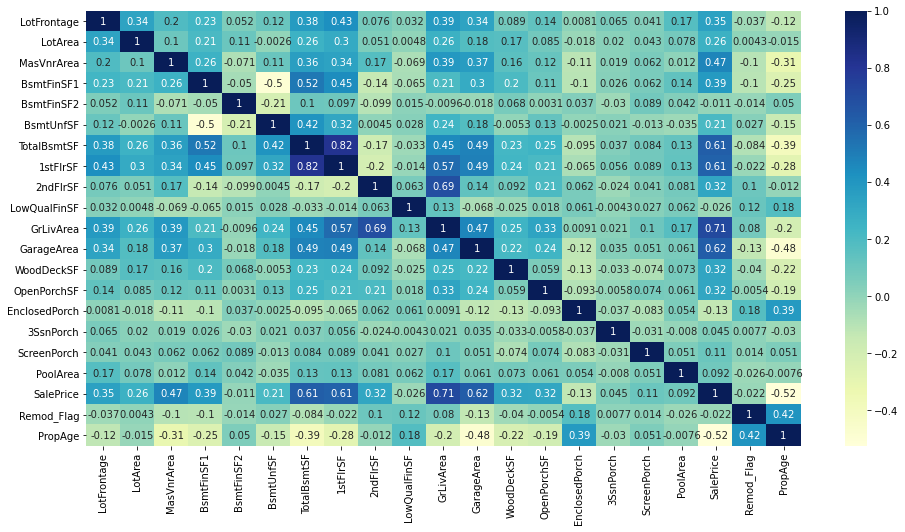

In [79]:
# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()


In [80]:
corr_sp=corr[['SalePrice']]

In [81]:
corr_sp.sort_values(by='SalePrice')

,SalePrice
PropAge,-0.523350
EnclosedPorch,-0.128578
LowQualFinSF,-0.025606
Remod_Flag,-0.021933
BsmtFinSF2,-0.011378
3SsnPorch,0.044584
PoolArea,0.092404
ScreenPorch,0.111447
BsmtUnfSF,0.214479
LotArea,0.263843


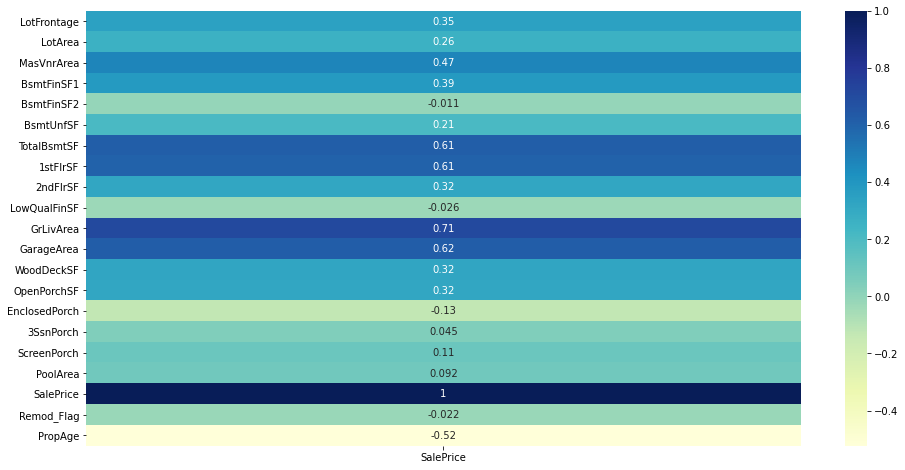

In [82]:
# Plotting correlations on a heatmap only wrt to SalePrice

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(corr_sp, cmap="YlGnBu", annot=True)
plt.show()


#### Remove outliers 

{'whiskers': [<matplotlib.lines.Line2D at 0x1df9301f1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1df9301f850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1df92e5ee50>],
 'medians': [<matplotlib.lines.Line2D at 0x1df9301ff10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1df930292b0>],
 'means': []}

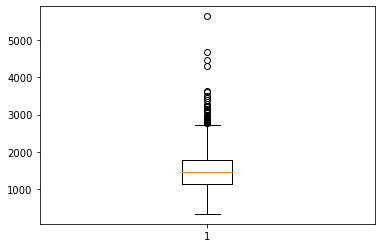

In [83]:
#Checking GrLivArea as it has the highest corelation with price
plt.boxplot(House_attributes['GrLivArea'])


In [84]:
#Defining function for outlier treatment
def remove_outliers(x,y):
    q1 = x[y].quantile(0.25)
    q3 = x[y].quantile(0.75)
    value = q3-q1
    lower_value  = q1-1.5*value
    higer_value = q3+1.5*value
    out= x[(x[y]<higer_value) & (x[y]>lower_value)]
    return out

In [85]:
House_attributes = remove_outliers(House_attributes,'GrLivArea')

In [86]:
House_attributes.shape


(1429, 67)

Here 31 rows deleted. We cant afford to loose a lot of rows as the dataset is small,
hence limiting the outlier treatment to a single column."GrLivArea" is also the column with max correlation with SalePrice

#### Treating the categorical variables like creating dummies

In [87]:
categorical_columns=[column for column in House_attributes.columns if column not in  House_attributes.describe().columns]

In [88]:
len(categorical_columns)

46

In [89]:
House_attributes_categorical=House_attributes[categorical_columns]

In [90]:
# Convert into dummies

House_attributes_categorical_dummies = pd.get_dummies(House_attributes_categorical, drop_first=True)
House_attributes_categorical_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [91]:
# Drop categorical variable columns
House_attributes = House_attributes.drop(list(House_attributes_categorical.columns), axis=1)

In [92]:
# Concatenate dummy variables with the original dataframe
House_attributes = pd.concat([House_attributes, House_attributes_categorical_dummies], axis=1)

In [93]:
len(House_attributes)

1429

In [94]:
len(House_attributes.columns)

269

In [95]:
House_attributes.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,1,0,0,0,1,0


#### Checking target(SalePrice) variable's distribution incase transformations are required

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

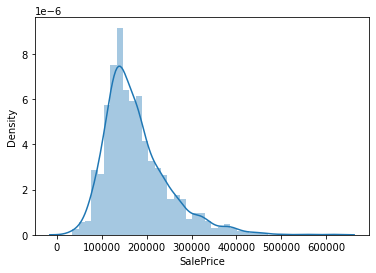

In [96]:
sns.distplot(House_attributes['SalePrice'])


It is observed that its shifted towards the left, hence log transformation can be tried

In [97]:
House_attributes['SalePrice']=np.log1p(House_attributes['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

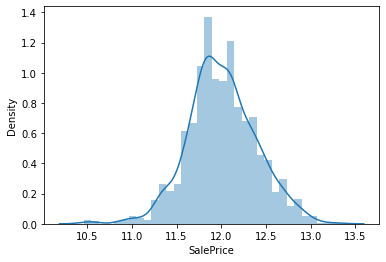

In [98]:
sns.distplot(House_attributes['SalePrice'])


Now the distribution is more propely distributed

#### Creating train and test datasets

In [99]:
# Split the dataframe into train and test sets
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(House_attributes, train_size=0.7, test_size=0.3, random_state=100)

In [100]:
df_train.head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
127,55.0,4388,0.0,116,0,556,672,840,0,0,...,0,0,0,0,1,0,0,0,1,0


#### Scaling


In [101]:
from sklearn.preprocessing import MinMaxScaler 

In [102]:
scaler = MinMaxScaler()

In [103]:
# Apply scaler() to all the numeric variables
numeric_columns=House_attributes.describe().columns
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

In [104]:
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

In [105]:
df_train.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.166661,0.042393,0.054857,0.238289,0.031987,0.237677,0.322416,0.351853,0.199983,0.008553,...,0.003000,0.002000,0.079000,0.003000,0.872000,0.003000,0.007000,0.013000,0.829000,0.080000
std,0.070910,0.047878,0.097960,0.232556,0.108905,0.186153,0.128764,0.154161,0.254172,0.077140,...,0.054717,0.044699,0.269874,0.054717,0.334257,0.054717,0.083414,0.113331,0.376697,0.271429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.029224,0.000000,0.000000,0.000000,0.093322,0.246959,0.238365,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.167808,0.037573,0.000000,0.208840,0.000000,0.200771,0.304117,0.324489,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.202055,0.047233,0.086094,0.390331,0.000000,0.339576,0.393091,0.442149,0.435754,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
df_test.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,...,429.000000,429.000000,429.000000,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.164771,0.041805,0.075626,0.243975,0.030507,0.245983,0.330997,0.355216,0.210373,0.007337,...,0.004662,0.006993,0.083916,0.0,0.867133,0.002331,0.009324,0.016317,0.815851,0.088578
std,0.073443,0.041290,0.121396,0.246467,0.112003,0.189567,0.121194,0.159048,0.265007,0.075603,...,0.068199,0.083429,0.277586,0.0,0.339827,0.048280,0.096222,0.126840,0.388058,0.284466
min,0.000000,0.001089,0.000000,0.000000,0.000000,0.000000,0.000000,0.064811,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.028232,0.000000,0.000000,0.000000,0.095462,0.247973,0.230535,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.167808,0.038220,0.000000,0.212155,0.000000,0.202911,0.313475,0.321009,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.202055,0.047559,0.122500,0.386740,0.000000,0.348459,0.407361,0.466725,0.452514,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.551370,0.737105,0.705625,1.208840,0.764586,0.815497,0.787274,0.952588,0.885785,0.973485,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
# X,y from train dataset
y_train = df_train.pop('SalePrice')
X_train = df_train

In [108]:
# X,y from test dataset
y_test = df_test.pop('SalePrice')
X_test = df_test

### 3. Model building and evaluation

#### Trying with a simple linear regression model with all features

In [109]:
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [110]:
# Print the coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[ 3.57751614e-02  1.98793957e-01  1.38733194e-02 -2.65615323e+10
 -2.16307727e+10 -3.42805190e+10  4.70476643e+10 -7.03346567e+09
 -4.92862688e+09 -1.61534140e+09  7.33022347e+09  3.27281952e-02
  3.20959091e-02  9.28282738e-03  1.65770650e-02  5.06882668e-02
  3.22954655e-02  7.97198415e-02 -3.23295593e-03 -1.06686354e-01
 -1.29709244e-02  1.88999176e-02 -1.22094154e-02 -1.11110210e-02
 -3.29847336e-02 -9.50431824e-03 -1.67624950e-02 -2.94003487e-02
 -3.56731415e-02 -8.69253798e+09 -2.99206972e-02 -9.07211304e-02
 -6.37950897e-02 -8.83936882e-04  1.48946285e-01  1.21860892e-01
  1.27346039e-01  1.07975483e-01  3.57294083e-03  5.49316406e-04
  2.93540955e-03  4.97829914e-03 -1.52301788e-03  1.64794922e-03
  1.29127502e-02 -1.06763840e-02 -3.10221314e-02 -5.92851639e-03
  4.96053696e-03 -5.54200411e-02 -2.83956528e-03  7.33077526e-03
  2.74562836e-02  2.76894569e-02  5.81383705e-03  5.56802750e-02
 -1.45378113e-02  4.61983681e-03  8.69703293e-03 -3.41420174e-02
 -4.96435165e-03  1.16109

In [111]:
from sklearn.metrics import r2_score, mean_squared_error

In [112]:
#Checking the metrics for the linear regression model
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9484181135080976
-6.319540998391936e+17
0.984411205989626
5.344364774437812e+18
0.0009844112059896259
1.2457726746941288e+16


It can be cleary seen , numbers are not good and errors are high. Other models needs to be tested

#### Trying out Ridge regression

In [113]:
# Creating a list of alphas for regularisation
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
# 5 fold cross validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge,param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.2s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [114]:
#Best scores and params
print(ridge_model_cv.best_params_)
print(ridge_model_cv.best_score_)


{'alpha': 2.0}
-0.030783810566601833


In [115]:
ridge_cv_df = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013603,0.006434,0.007091,0.004070,0.0001,{'alpha': 0.0001},-0.031133,-0.033902,-0.038099,-0.029352,...,-0.033730,0.003192,24,-0.021349,-0.020786,-0.020446,-0.021216,-0.020442,-0.020848,0.000379
1,0.016013,0.003146,0.007813,0.001467,0.001,{'alpha': 0.001},-0.031114,-0.033894,-0.038056,-0.029331,...,-0.033708,0.003187,23,-0.021353,-0.020787,-0.020450,-0.021219,-0.020442,-0.020850,0.000379
2,0.014410,0.002101,0.005655,0.000962,0.01,{'alpha': 0.01},-0.030942,-0.033822,-0.037686,-0.029140,...,-0.033514,0.003141,22,-0.021386,-0.020798,-0.020480,-0.021251,-0.020448,-0.020873,0.000386
3,0.014630,0.003204,0.005024,0.002879,0.05,{'alpha': 0.05},-0.030411,-0.033553,-0.036685,-0.028647,...,-0.032946,0.003015,21,-0.021525,-0.020861,-0.020601,-0.021362,-0.020478,-0.020965,0.000413
4,0.018803,0.003384,0.007413,0.001892,0.1,{'alpha': 0.1},-0.029968,-0.033394,-0.035957,-0.028286,...,-0.032523,0.002940,19,-0.021656,-0.020948,-0.020713,-0.021474,-0.020530,-0.021064,0.000434
5,0.016780,0.003012,0.007668,0.001610,0.2,{'alpha': 0.2},-0.029386,-0.033337,-0.035026,-0.027798,...,-0.032019,0.002896,18,-0.021849,-0.021111,-0.020907,-0.021694,-0.020674,-0.021247,0.000453
6,0.013363,0.003537,0.005545,0.002894,0.3,{'alpha': 0.3},-0.029086,-0.033278,-0.034546,-0.027536,...,-0.031737,0.002870,17,-0.022001,-0.021270,-0.021075,-0.021890,-0.020803,-0.021408,0.000465
7,0.011867,0.002290,0.005591,0.002961,0.4,{'alpha': 0.4},-0.028901,-0.033219,-0.034241,-0.027378,...,-0.031555,0.002851,16,-0.022149,-0.021414,-0.021221,-0.022072,-0.020909,-0.021553,0.000483
8,0.011471,0.001900,0.001639,0.001820,0.5,{'alpha': 0.5},-0.028745,-0.033160,-0.034004,-0.027259,...,-0.031410,0.002837,13,-0.022292,-0.021549,-0.021358,-0.022235,-0.021013,-0.021689,0.000500
9,0.013525,0.002286,0.003996,0.003486,0.6,{'alpha': 0.6},-0.028621,-0.033125,-0.033824,-0.027166,...,-0.031300,0.002830,11,-0.022431,-0.021667,-0.021487,-0.022376,-0.021103,-0.021813,0.000516


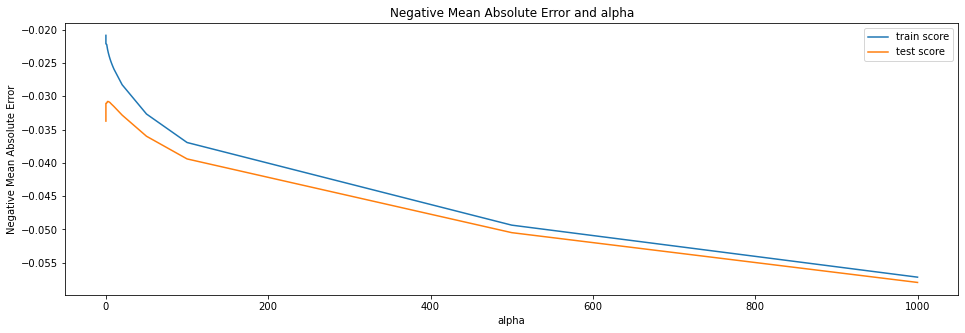

In [116]:
# plotting mean test and train scoes with alpha 
ridge_cv_df['param_alpha'] = ridge_cv_df['param_alpha'].astype('int32')
plt.figure(figsize=(16,5))

# plotting
plt.plot(ridge_cv_df['param_alpha'], ridge_cv_df['mean_train_score'])
plt.plot(ridge_cv_df['param_alpha'], ridge_cv_df['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

Lets zoom into the graph by filtering for records

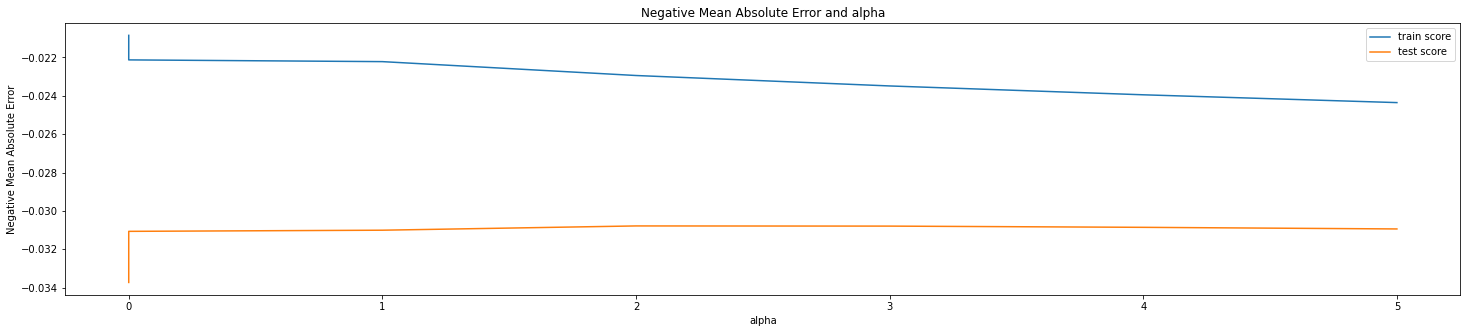

In [117]:
ridge_cv_df = ridge_cv_df[ridge_cv_df['param_alpha']<=5]
plt.figure(figsize=(25,5))

# plotting
plt.plot(ridge_cv_df['param_alpha'], ridge_cv_df['mean_train_score'])
plt.plot(ridge_cv_df['param_alpha'], ridge_cv_df['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()



#### Here in the graph and from the "best_params_" parameter it can be seen that the optimum alpha for ridge regression is 2.

#### Hence running the model with alpha as 2 and checking the predictions

In [118]:
alpha = ridge_model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 2.80100201e-02,  5.78342554e-02,  1.26143284e-02,  5.55353378e-02,
        3.67909043e-02,  2.24212381e-02,  6.46053545e-02,  7.25498007e-02,
        4.93738889e-02,  7.77166012e-03,  1.04522856e-01,  2.71650288e-02,
        3.24544527e-02,  8.30202985e-03,  1.28902871e-02,  2.87181002e-02,
        2.85064380e-02,  3.93639467e-02, -3.96478765e-03, -5.90910621e-02,
       -1.47769343e-02,  2.90896487e-03,  6.59710057e-04, -1.32325550e-03,
       -1.16676931e-02,  8.24257378e-03, -5.28016662e-04, -3.91452201e-03,
       -1.02899014e-02,  1.62843128e-04, -2.22731201e-03, -3.84600400e-02,
       -7.22030611e-03,  4.92150974e-03,  5.33719723e-02,  3.13925888e-02,
        4.20743315e-02,  2.83431715e-02,  7.64353734e-03,  1.43614297e-02,
        2.00809232e-03,  6.50112003e-03, -6.10056743e-03,  4.52019140e-03,
        1.30999629e-02, -1.13089500e-02, -1.29567144e-02, -6.97405464e-03,
       -1.27838495e-03, -1.65713520e-02, -9.46829192e-03, -6.25866843e-03,
        8.17735062e-03,  

In [119]:
#lets check the R-squared value of train data predictions
y_train_pred = ridge.predict(X_train)
ridge_train_r2=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
print(ridge_train_r2)

0.9415187383849262


In [120]:
#lets check the R-squared value of test data predictions
y_test_pred = ridge.predict(X_test)
ridge_test_r2=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
print(ridge_test_r2)

0.9089636180621271


In [121]:
Difference = ridge_train_r2-ridge_test_r2
Difference

0.03255512032279906

#### The R squared values look good and as there is less difference between the train and test data values, overfitting is also prevented

#### Trying out Lasso regression

In [122]:
lasso = Lasso()

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.9s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [123]:
#checking the value of optimum number of parameters
print(lasso_model_cv.best_params_)
print(lasso_model_cv.best_score_)

{'alpha': 0.0001}
-0.030447673053420804


#### Let try the scores with alpha as 0.001 to balance bias vs variance trade off. Higher alpha will keep the model robust and simpler

In [124]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [125]:
#lets predict the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
lasso_train_r2=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
print(lasso_train_r2)

0.8871738764695702


In [126]:
#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)
lasso_test_r2=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
print(lasso_test_r2)

0.8830078244206411


In [127]:
difference = lasso_train_r2-lasso_test_r2
difference

0.00416605204892917

In [128]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, y_test_pred))

RMSE is: 
 0.0023062696408943212


In [129]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.29041580e-02,
        0.00000000e+00,  0.00000000e+00,  1.07452058e-01,  2.07138604e-03,
        0.00000000e+00, -0.00000000e+00,  2.16268219e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -2.03459988e-02,
       -1.54712141e-03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.10981249e-03,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.52720388e-02, -1.54349500e-02,  0.00000000e+00,  0.00000000e+00,
       -1.17715175e-03,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -5.30957680e-03,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [130]:
# lasso model parameters
model_parameters = list(lasso.coef_ )
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


[('constant', 0.335),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('MasVnrArea', 0.0),
 ('BsmtFinSF1', 0.053),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.107),
 ('1stFlrSF', 0.002),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', -0.0),
 ('GrLivArea', 0.216),
 ('GarageArea', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('Remod_Flag', -0.0),
 ('PropAge', -0.02),
 ('MSSubClass_30', -0.002),
 ('MSSubClass_40', -0.0),
 ('MSSubClass_45', 0.0),
 ('MSSubClass_50', -0.0),
 ('MSSubClass_60', 0.0),
 ('MSSubClass_70', 0.0),
 ('MSSubClass_75', -0.0),
 ('MSSubClass_80', 0.0),
 ('MSSubClass_85', -0.0),
 ('MSSubClass_90', -0.0),
 ('MSSubClass_120', -0.0),
 ('MSSubClass_160', -0.003),
 ('MSSubClass_180', -0.0),
 ('MSSubClass_190', -0.0),
 ('MSZoning_FV', 0.0),
 ('MSZoning_RH', 0.0),
 ('MSZoning_RL', 0.015),
 ('MSZoning_RM', -0.015),
 ('LotShape_IR2', 0.0),
 ('LotShape_IR3', 0.0),
 ('LotShape_Reg', 

In [131]:
# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

In [132]:
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

,Variable,Coeff
0,constant,0.335
1,LotFrontage,0.000
2,LotArea,0.000
3,MasVnrArea,0.000
4,BsmtFinSF1,0.053


In [133]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

,Variable,Coeff
0,constant,0.335
4,BsmtFinSF1,0.053
7,TotalBsmtSF,0.107
8,1stFlrSF,0.002
11,GrLivArea,0.216
...,...,...
248,GarageQual_NA,-0.004
250,GarageQual_TA,0.015
252,PavedDrive_Y,0.002
261,SaleType_New,0.037


In [134]:
# sort the coefficients in descending order to the high positive impact features
top_preds = pred.sort_values((['Coeff']), axis = 0, ascending = False)
top_preds

,Variable,Coeff
0,constant,0.335
11,GrLivArea,0.216
7,TotalBsmtSF,0.107
4,BsmtFinSF1,0.053
188,CentralAir_Y,0.047
...,...,...
96,OverallQual_4,-0.018
230,FireplaceQu_NA,-0.020
20,PropAge,-0.020
238,GarageType_NA,-0.030


In [135]:
top_preds.head(6)

,Variable,Coeff
0,constant,0.335
11,GrLivArea,0.216
7,TotalBsmtSF,0.107
4,BsmtFinSF1,0.053
188,CentralAir_Y,0.047
261,SaleType_New,0.037


In [136]:
# sort the coefficients in ascending order to the high negative impact features
bottom_preds = pred.sort_values((['Coeff']), axis = 0, ascending = True)
bottom_preds

,Variable,Coeff
104,OverallCond_3,-0.044
238,GarageType_NA,-0.030
230,FireplaceQu_NA,-0.020
20,PropAge,-0.020
96,OverallQual_4,-0.018
...,...,...
188,CentralAir_Y,0.047
4,BsmtFinSF1,0.053
7,TotalBsmtSF,0.107
11,GrLivArea,0.216


In [137]:
bottom_preds.head(4)

,Variable,Coeff
104,OverallCond_3,-0.044
238,GarageType_NA,-0.030
230,FireplaceQu_NA,-0.020
20,PropAge,-0.020


### 4. Inference

#### I would prefer Lasso Regression instead of Ridge because:-

- Even though the R2 was better for Ridge regression, Lasso regression had much lower difference between Train and test r2 scores, which highlights that there is no overfitting and its a robust model
- And in Lasso we have much lower number of features which again highlights that its robust


#### In terms of interpratation of some the top impacting features of the Lasso (Final) Model:-
##### Postive Factors -
- GrLivArea(0.216) : Greater living area definitely will lead to higher selling price hence its has highest weight
- TotalBsmtSF(0.107) : Hihger basement square feet area is surely likeable and hence better Saleprice
- BsmtFinSF1(0.053) : Higher finished basemnt areas obviously is preferable and leads to higher Saleprice
- CentralAir_Y(0.047) : Air conditioning is always preferable for inhibitants hence leads to higher SalePrice
- SaleType_New(0.037) : New constructed houses are always in demand hence leads to higher Sale price
##### Negative Factors -
- GarageType_NA(-0.030) : If a house doesnt have garage , it definitely pull the house price which is what suggested by our model as it is the feature with highest -ve impact on Sale Price
- FireplaceQu_NA(-0.020) : In US temparatures can go very low as well, so not having a fireplace definitely is a negative factor in terms of demand for a house
- PropAge(-0.020) : Higher property age means the house is older hence pulling down the sale price makes sense

#### Optimal values for Lambda:-
- Ridge: 2.0
- Lasso: 0.001


### APPENDIX :- For Subjective questions

In [138]:
alpha = 0.002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

#lets predict the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
lasso_train_r2=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
print(lasso_train_r2)

#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)
lasso_test_r2=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
print(lasso_test_r2)

difference = lasso_train_r2-lasso_test_r2
difference

0.8394931082565242
0.8434734624676195


-0.003980354211095216

In [139]:
# lasso model parameters
model_parameters = list(lasso.coef_ )
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

# sort the coefficients in descending order to the high positive impact features
top_preds = pred.sort_values((['Coeff']), axis = 0, ascending = False)
top_preds

top_preds.head(11)

,Variable,Coeff
0,constant,0.383
11,GrLivArea,0.192
7,TotalBsmtSF,0.063
188,CentralAir_Y,0.052
4,BsmtFinSF1,0.048
244,GarageCars_3,0.034
168,BsmtExposure_Gd,0.021
156,Foundation_PConc,0.020
37,MSZoning_RL,0.017
250,GarageQual_TA,0.017


In [140]:
alpha = 4.0#ridge_model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

#lets check the R-squared value of train data predictions
y_train_pred = ridge.predict(X_train)
ridge_train_r2=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
print(ridge_train_r2)

#lets check the R-squared value of test data predictions
y_test_pred = ridge.predict(X_test)
ridge_test_r2=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
print(ridge_test_r2)

Difference = ridge_train_r2-ridge_test_r2
Difference

0.937452317088628
0.9078485502948418


0.02960376679378618

In [141]:
# lasso model parameters
model_parameters = list(ridge.coef_ )
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

# sort the coefficients in descending order to the high positive impact features
top_preds = pred.sort_values((['Coeff']), axis = 0, ascending = False)
top_preds

top_preds.head(11)

,Variable,Coeff
0,constant,0.348
11,GrLivArea,0.094
8,1stFlrSF,0.069
7,TotalBsmtSF,0.058
4,BsmtFinSF1,0.053
101,OverallQual_9,0.047
56,Neighborhood_Crawfor,0.041
9,2ndFlrSF,0.040
35,MSZoning_FV,0.039
2,LotArea,0.037


In [142]:
#################

In [143]:
alpha = 0.001

lasso = Lasso(alpha=alpha)

X_train.drop(['GrLivArea','TotalBsmtSF','BsmtFinSF1','CentralAir_Y','SaleType_New'],axis=1,inplace=True)   
X_test.drop(['GrLivArea','TotalBsmtSF','BsmtFinSF1','CentralAir_Y','SaleType_New'],axis=1,inplace=True)   
    
lasso.fit(X_train, y_train) 

#lets predict the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
lasso_train_r2=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
print(lasso_train_r2)

#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)
lasso_test_r2=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
print(lasso_test_r2)

difference = lasso_train_r2-lasso_test_r2
difference

0.8749871315943976
0.8698826999093856


0.005104431685011956

In [144]:
# lasso model parameters
model_parameters = list(ridge.coef_ )
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

# sort the coefficients in descending order to the high positive impact features
top_preds = pred.sort_values((['Coeff']), axis = 0, ascending = False)
top_preds

top_preds.head(11)

,Variable,Coeff
0,constant,0.348
11,OpenPorchSF,0.094
8,LowQualFinSF,0.069
7,2ndFlrSF,0.058
4,BsmtFinSF2,0.053
101,OverallCond_3,0.047
56,Neighborhood_IDOTRR,0.041
9,GarageArea,0.040
35,MSZoning_RM,0.039
2,LotArea,0.037


In [145]:
bottom_preds = pred.sort_values((['Coeff']), axis = 0, ascending = True)
bottom_preds

bottom_preds.head(11)

,Variable,Coeff
104,OverallCond_6,-0.061
20,MSSubClass_45,-0.044
94,OverallQual_5,-0.041
60,Neighborhood_NPkVill,-0.038
95,OverallQual_6,-0.038
148,ExterCond_Fa,-0.035
32,MSZoning_FV,-0.032
212,TotRmsAbvGrd_4,-0.031
203,BedroomAbvGr_5,-0.026
214,TotRmsAbvGrd_6,-0.024
